<a href="https://colab.research.google.com/github/makingthefuturehappy/ML_FLASK/blob/master/NN_Nucleus_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Intro
### Основная идея: Делаем решение на базе U-Net

In [22]:
import os
import sys
import glob
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')
file_path = 'https://drive.google.com/drive/folders/1NMsapf6rK0bMR3MkfU8942nxQ3qAe9zo?usp=sharing'

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
tf.test.gpu_device_name() ## check GPU
!nvidia-smi -L ##GPU count and name

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Skimage      : 0.16.2
Keras        : 2.4.3
Tensorflow   : 2.3.0
GPU 0: Tesla K80 (UUID: GPU-3f7a20ec-4dff-24c1-bb85-3f593241a72d)


In [3]:
# Common Variables and PATHs
PATH = '/content/'
PATH_GDRIVE = '/content/drive/My Drive/Colab Notebooks/NN Nucleus Detection/'

TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 3

BATCH_SIZE      = 32
NUM_EPOCHS      = 50
# STEPS_PER_EPOCH = 600
LR              = 0.001
validation_split= 0.1

In [4]:
#@title Notifications Setup
%%capture
import requests
import json

%cp -av '/content/drive/My Drive/Colab Notebooks/NN Nucleus Detection/token_telegram.json' '/content'
!pip install gTTS #text to Speach lib for notifications

from gtts import gTTS
from IPython.display import Audio
def Notification(text = 'task is done'):
  tts = gTTS(text)
  print(text)
  tts.save('notification.wav')
  sound_file = 'notification.wav'
  return Audio(sound_file, autoplay=True)

with open(PATH_GDRIVE + 'token_telegram.json', 'r') as credentials:
  telegram = json.load(credentials)
token = telegram['token']
chat_id = telegram['chat_id']

def send_telegram(text, token = token, chat_id = chat_id):  
  url = "https://api.telegram.org/bot" + token
  mess = 'https://api.telegram.org/bot' + token + '/sendMessage?chat_id=' + chat_id +'&text=' + text
  response = requests.get(mess)
  return response

Notification('Setup is done.')

In [5]:
# seed values
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

# SETUP

In [6]:
# SETUP
PATH = '/content/'
PATH_GDRIVE = '/content/drive/My Drive/Colab Notebooks/NN Nucleus Detection/'

TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 3

BATCH_SIZE      = 32
NUM_EPOCHS      = 50
# STEPS_PER_EPOCH = 600
LR              = 0.001
validation_split= 0.1

# 1. Load Data
распаковываем данные

In [8]:
# распаковываем данные
import zipfile

for name_data in ['test', 'train']:
    tmp_zip = zipfile.ZipFile(PATH_GDRIVE + name_data+'.zip')
    tmp_zip.extractall(name_data)
    tmp_zip.close()

%cp -av '/content/drive/My Drive/Colab Notebooks/NN Nucleus Detection/sample_submission.csv' '/content'
%cp -av '/content/drive/My Drive/Colab Notebooks/NN Nucleus Detection/train_labels.csv' '/content'

print('data uploaded...')

'/content/drive/My Drive/Colab Notebooks/NN Nucleus Detection/sample_submission.csv' -> '/content/sample_submission.csv'
'/content/drive/My Drive/Colab Notebooks/NN Nucleus Detection/train_labels.csv' -> '/content/train_labels.csv'
data uploaded...


# Data Analysis

Для начала глянем csv

In [22]:
sample_submission = pd.read_csv(PATH_GDRIVE + 'sample_submission.csv')
sample_submission.sample(5)

,ImageId,EncodedPixels
53,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,1 1
60,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,1 1
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,1 1
45,a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...,1 1
5,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,1 1


In [23]:
len(sample_submission)

65

Не кажеться странным, что нам предлагают на тест только 65 уникальных картинок? )  
посмотрим что в трейне...

In [24]:
train_labels = pd.read_csv(PATH_GDRIVE + 'train_labels.csv')
train_labels.sample(10)

,ImageId,EncodedPixels
16141,8b77284d6f37ab3fc826139ebadaec3b9d81c552fe525c...,55530 7 55784 12 56039 14 56294 16 56549 18 56...
27194,ea94ba4b01d1bd5f7768d10e0ac547743791033df545c7...,12295 8 12550 11 12805 14 13060 17 13316 18 13...
24216,cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9...,37435 5 37690 7 37945 8 38201 8 38457 8 38713 ...
25304,da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e751...,18647 6 19166 8 19686 9 20206 9 20726 8 21247 ...
21273,b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d4...,331026 5 331543 9 332062 12 332580 15 333099 1...
9796,538b7673d507014d83af238876e03617396b70fe27f525...,127462 4 128064 8 128666 12 129268 16 129870 2...
3410,1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526...,431986 4 433009 5 434033 5 435057 6 436081 6 4...
16126,8aa1a883f61f0bb5af3d3d60acaaf33af45ef4fbffaac1...,59092 3 59345 8 59600 11 59856 11 60112 11 603...
9577,4e23ecf65040f86420e0201134e538951acdeda84fbb27...,55041 2 55297 4 55553 5 55809 6 56065 6 56321 ...
27756,ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5...,23588 3 23843 5 24099 5 24355 5 24612 3


In [26]:
len(train_labels)

29461

в описании датасета написано что "Каждая маска содержит одно ядро."  
А из всех 29к примеров, сколько у нас уникальных изображений для тренировки на самом деле?

In [27]:
len(train_labels) - train_labels.ImageId.duplicated().sum()

670

Сверяем по папкам

In [28]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))
test_ids = next(os.walk(TEST_PATH))

mask_count = 0
for train_id in train_ids[1]:
    masks = next(os.walk(TRAIN_PATH + train_id + '/masks/'))[2]
    mask_count += len(masks)

print('There are {} images.'.format(len(train_ids[1])))
print('There are {} masks.'.format(mask_count))
print('Approximately {} masks per image.'.format(mask_count // len(train_ids[1])))

There are 670 images.
There are 29461 masks.
Approximately 43 masks per image.


Вот все и встало на свои места, Итого 65 изображений на тесте и 670 на трейне.  
Давай подгрузим и посмотрим эти картинки

#Data Preparation

In [9]:
# для подгрузки данных будем использовать удобную либу skimage
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], 
                                                output_shape=output_shape, 
                                                mode='constant', 
                                                preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data

In [10]:
%%time
# Get training data
X_train = get_X_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(X_train.shape, X_train.dtype)

(670, 256, 256, 3) uint8
CPU times: user 20.2 s, sys: 15.7 s, total: 35.8 s
Wall time: 18.7 s


In [11]:
def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data

In [12]:
%%time
# Get training data labels
Y_train = get_Y_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(Y_train.shape, Y_train.dtype)

(670, 256, 256, 1) bool
CPU times: user 1min 10s, sys: 37.4 s, total: 1min 48s
Wall time: 1min 9s


In [ ]:
# Check training data
f, axarr = plt.subplots(2,4)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,1].imshow(np.squeeze(Y_train[ix]))

axarr[0,2].imshow(X_train[ix])
axarr[0,3].imshow(np.squeeze(Y_train[ix]))

axarr[1,0].imshow(X_train[ix])
axarr[1,1].imshow(np.squeeze(Y_train[ix]))

axarr[1,2].imshow(X_train[ix])
axarr[1,3].imshow(np.squeeze(Y_train[ix]))

plt.show()

#TensorBoard Setup

In [ ]:
%load_ext tensorboard

# %reload_ext tensorboard
!rm -rf ./logs/ #clean existing logs

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
metrics_callback = tf.keras.callbacks.TensorBoard(logdir)

%tensorboard --logdir logs

# 2. Build model

> Построим U-Net model, по мотивам [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) и близко к этому [репозиторию](https://github.com/jocicmarko/ultrasound-nerve-segmentation) из Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [15]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
#c5 = BatchNormalization() (c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
optimizer = Adam(lr=LR,)
model.compile(optimizer=optimizer, loss='binary_crossentropy',)
# model.summary()

In [17]:
# Fit model
history = model.fit(X_train, Y_train, 
                    validation_split=validation_split, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    verbose=1,
                    # callbacks = [metrics_callback,
                #  model_checkpoint_save,
                #  EarlyStopping,
                #  Reduce_LR,
                #  CustomCallback()
                #  ]
                    )

Epoch 1/50
19/19 [==============================] - 11s 572ms/step - loss: 0.1377 - val_loss: 0.1576
Epoch 2/50
19/19 [==============================] - 11s 573ms/step - loss: 0.1144 - val_loss: 0.1196
Epoch 3/50
19/19 [==============================] - 11s 576ms/step - loss: 0.1042 - val_loss: 0.1214
Epoch 4/50
19/19 [==============================] - 11s 574ms/step - loss: 0.1088 - val_loss: 0.1236
Epoch 5/50
19/19 [==============================] - 11s 576ms/step - loss: 0.1043 - val_loss: 0.1136
Epoch 6/50
19/19 [==============================] - 11s 574ms/step - loss: 0.0937 - val_loss: 0.0929
Epoch 7/50
19/19 [==============================] - 11s 576ms/step - loss: 0.0871 - val_loss: 0.0931
Epoch 8/50
19/19 [==============================] - 11s 575ms/step - loss: 0.0863 - val_loss: 0.0856
Epoch 9/50
19/19 [==============================] - 11s 575ms/step - loss: 0.0813 - val_loss: 0.0857
Epoch 10/50
19/19 [==============================] - 11s 576ms/step - loss: 0.0796 - val_lo

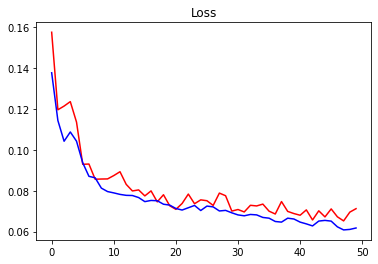

In [18]:
def plot_loss_history(history):
    # validation losses
    val_loss = history.history['val_loss']
    loss = history.history['loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.show()
    
plot_loss_history(history)

In [23]:
model.save(PATH_GDRIVE + 'models/' + 'keras_unet_baseline.h5')

# 3. Make predictions

In [ ]:
# Use model to predict train labels
model = load_model('keras_unet.h5',)
Y_predict = model.predict(X_train, verbose=1)
Y_predict.shape

NameError: ignored

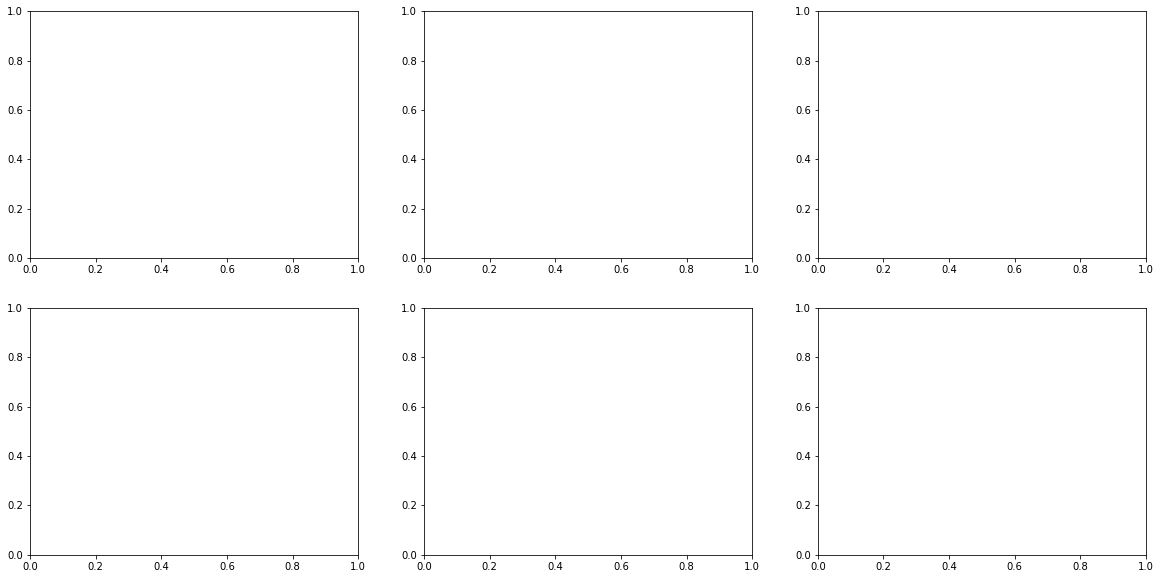

In [25]:
# Check predict data
f, axarr = plt.subplots(2,3)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,0].set_title('Microscope')
axarr[0,1].imshow(np.squeeze(Y_predict[ix]))
axarr[0,1].set_title('"Predicted" Masks')
axarr[0,2].imshow(np.squeeze(Y_train[ix]))
axarr[0,2].set_title('"GroundTruth" Masks')

axarr[1,0].imshow(X_train[ix])
axarr[1,0].set_title('Microscope')
axarr[1,1].imshow(np.squeeze(Y_predict[ix]))
axarr[1,1].set_title('"Predicted" Masks')
axarr[1,2].imshow(np.squeeze(Y_train[ix]))
axarr[1,2].set_title('"GroundTruth" Masks')

plt.show()

Смотриться хорошо

In [ ]:
# Get test data
X_test = get_X_data(TEST_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))

# Use model to predict test labels
Y_hat = model.predict(X_test, verbose=1)
Y_hat.shape

65/65 [==============================] - 0s 5ms/step


(65, 256, 256, 1)

(256, 256, 3)


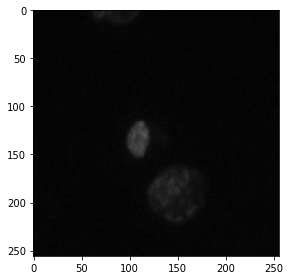

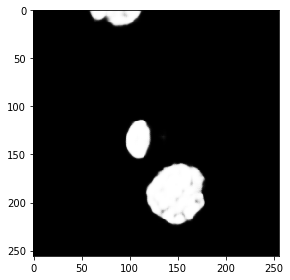

In [ ]:
idx = random.randint(0, len(test_ids[1]))
print(X_test[idx].shape)
skimage.io.imshow(X_test[idx])
plt.show()
skimage.io.imshow(Y_hat[idx][:,:,0])
plt.show()

# 4. Encode and Submit

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

мы ресайзили картинку до 256х256, но чтоб верно предсказать, нам нужно сделать маску под размер изначальной картинки

In [ ]:
# Upsample Y_hat back to the original X_test size (height and width)
Y_hat_upsampled = []
for i, test_id in enumerate(os.listdir(TEST_PATH)):  #loop through test_ids in the test_path
    img = skimage.io.imread('{0}/{1}/images/{1}.png'.format(TEST_PATH, test_id))  #read original test image directly from path
    img_upscaled = skimage.transform.resize(Y_hat[i], (img.shape[0], img.shape[1]), mode='constant', preserve_range=True)  #upscale Y_hat image according to original test image
    Y_hat_upsampled.append(img_upscaled)   #append upscaled image to Y_hat_upsampled
len(Y_hat_upsampled)

65

Осталось закодировать нашу маску

In [ ]:
# Apply Run-Length Encoding on our Y_hat_upscaled
new_test_ids = []
rles = []
for n, id_ in enumerate(os.listdir(TEST_PATH)):
    rle = list(prob_to_rles(Y_hat_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
len(new_test_ids)  #note that for each test_image, we can have multiple entries of encoded pixels

2230

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission.csv', index=False)

In [ ]:
sub.head()

,ImageId,EncodedPixels
0,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,1 29 520 30 1039 29 1558 26 2077 21 2596 15 31...
1,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,44 29 562 31 1080 32 1598 33 2117 33 2636 34 3...
2,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,170 23 688 25 1207 25 1725 26 2244 26 2762 27 ...
3,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,407 47 926 50 1445 52 1965 54 2485 55 3005 55 ...
4,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,4553 5 5070 8 5588 10 6105 12 6623 14 7141 15 ...


In [ ]:
len(sub)

2230

In [ ]:
# Clean Folder
import shutil
shutil.rmtree('train')
shutil.rmtree('test')

Готово!

## Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Добавить свою метрику (для сегментации loss не лучшая метрика) и callbacks по ней
* Поставить и подобрать Threshold для predictions
* Добавить аугментацию
* Поиграться с архитектурой
* Подобрать другие переменные (размер картинки, батч и тп)
* Добавить политику обучения
* Добавить TTA
* Найти и обучиться на других внешних данных
* Построить ансамбль из разных архитектур

Удачи в соревновании!